# Modules

In [1]:
import timm
from fastai.vision.all import *
from fastai.vision.widgets import *
import os

os.environ["TORCH_HOME"] = "/media/hdd/Datasets/"
os.environ["FASTAI_HOME"] = "/media/hdd/Datasets/"

# Train

In [2]:
root_dir = "/media/hdd/Datasets/DenseHaze/"
path = Path(root_dir)

In [3]:
path.ls()

(#2) [Path('/media/hdd/Datasets/DenseHaze/masks'),Path('/media/hdd/Datasets/DenseHaze/train')]

In [4]:
def file_repl(x):
    if "masks" in str(x):
        return Path(str(x).replace("masks", "train"))
    else:
        return Path(str(x).replace("train", "masks"))

In [53]:
def ret(o):
    return o.parent.parent / "masks" / o.name


ret(Path("/media/hdd/Datasets/DenseHaze/train/43.png"))

Path('/media/hdd/Datasets/DenseHaze/masks/43.png')

In [89]:
fields = DataBlock(
    blocks=(ImageBlock(cls=PILImage), ImageBlock(cls=PILImage)),
    get_items=get_image_files,
    #     get_y= lambda o:o.parent.parent/'train'/o.name,
    get_y=lambda o: o,
    #     splitter=GrandparentSplitter(),
    splitter=RandomSplitter(),
    item_tfms=Resize(32),
    #     batch_tfms=aug_transforms(),
)
dls = fields.dataloaders(path, path=path, bs=10)

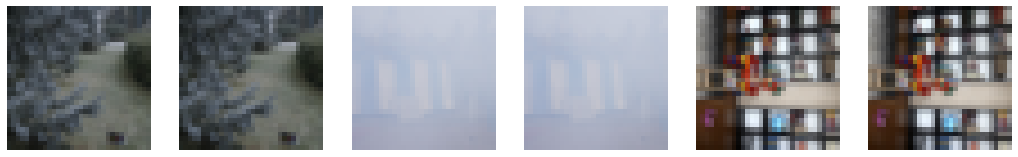

In [90]:
dls.show_batch(max_n=3)

In [91]:
arch = create_body(xresnet18, n_in=1).cuda()


class UpsampleBlock(Module):
    def __init__(
        self,
        up_in_c: int,
        final_div: bool = True,
        blur: bool = False,
        leaky: float = None,
        **kwargs
    ):
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c // 2, blur=blur, **kwargs)
        ni = up_in_c // 2
        nf = ni if final_div else ni // 2
        self.conv1 = ConvLayer(ni, nf, **kwargs)
        self.conv2 = ConvLayer(nf, nf, **kwargs)
        self.relu = nn.ReLU()

    def forward(self, up_in: Tensor) -> Tensor:
        up_out = self.shuf(up_in)
        cat_x = self.relu(up_out)
        return self.conv2(self.conv1(cat_x))


def decoder_resnet(y_range, n_out=1):
    return nn.Sequential(
        UpsampleBlock(512),
        UpsampleBlock(256),
        UpsampleBlock(128),
        UpsampleBlock(64),
        UpsampleBlock(32),
        nn.Conv2d(16, n_out, 1),
        SigmoidRange(*y_range),
    )


def autoencoder(encoder, y_range):
    return nn.Sequential(encoder, decoder_resnet(y_range))


y_range = (-3.0, 3.0)
ac_resnet = autoencoder(arch, y_range).cuda()
dec = decoder_resnet(y_range).cuda()

AttributeError: 'function' object has no attribute 'named_parameters'

In [86]:
learn = Learner(dls, ac_resnet, loss_func=MSELossFlat())
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,time


/home/eragon/mambaforge/envs/pytorcher/lib/python3.10/site-packages/torch/_tensor.py:1142: UserWarning: Using a target size (torch.Size([30720])) that is different to the input size (torch.Size([10240])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  ret = func(*args, **kwargs)


RuntimeError: The size of tensor a (10240) must match the size of tensor b (30720) at non-singleton dimension 0